# Camera Calibration Example

## Generate data

In [1]:
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import least_squares

# import the necessary modules
from zodipol.utils.argparser import ArgParser
from zodipol.zodipol import Zodipol, Observation
from zodipol.visualization.skymap_plots import plot_satellite_image, plot_satellite_image_indices

In [3]:
parser = ArgParser(args=['-res', '300', '200', '--fov', '180', '-dir', '90', '40', '-par', '-ip', 'exposure_time', '10*u.s'])

In [4]:
zodipol = Zodipol(polarizance=parser["polarizance"], fov=parser["fov"], n_polarization_ang=parser["n_polarization_ang"], parallel=parser["parallel"], n_freq=parser["n_freq"], planetary=parser["planetry"], isl=parser["isl"], resolution=parser["resolution"], imager_params=parser["imager_params"])
obs = zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], lonlat=False, new_isl=parser["new_isl"])

/mnt/d/CodingProjects/zodiacal-polarized/zodipol/zodipy_local/zodipy_local/_source_funcs.py:28: RuntimeWarning: overflow encountered in expm1
  term2 = np.expm1((h * freq) / (k_B * T))


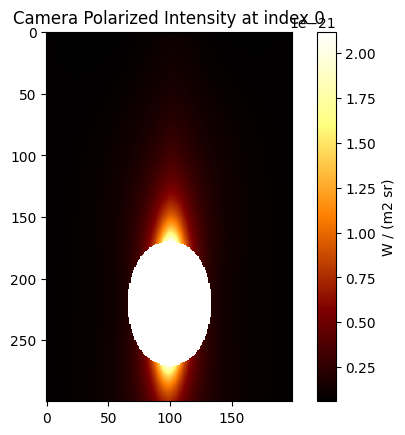

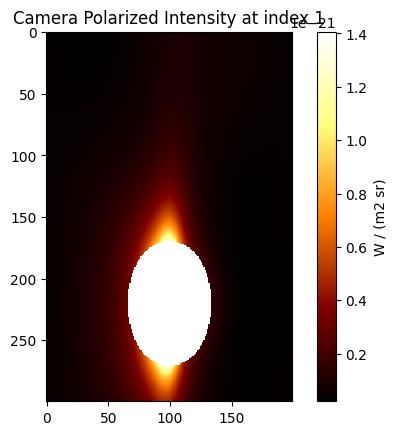

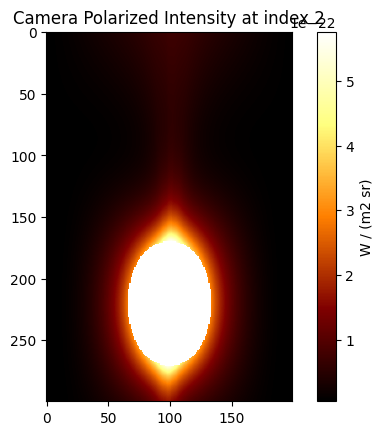

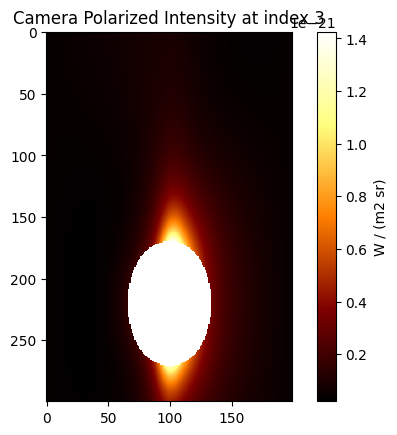

In [5]:
camera_intensity = zodipol.make_camera_images(obs, n_realizations=parser["n_realizations"], add_noise=False)
plot_satellite_image_indices(camera_intensity, 4, resolution=parser["resolution"], title="Camera Polarized Intensity")

## Camera polarizer angler calibration

In [12]:
polarizance = parser["polarizance"]  # Polarizance of the observation
polarization_angle_diff = np.pi / parser["n_polarization_ang"]  # Polarization angle difference between the polarization angles

polarization_shift_list = np.linspace(0, np.pi, 10)
calibration_results = []
for polarization_shift in polarization_shift_list:
    polarization_angle = polarization_shift + parser["polarization_angle"]  # Polarization angle of the observation
    df_ind = polarization_angle_diff * np.arange(parser["n_polarization_ang"])
    make_img = lambda eta: zodipol.make_camera_images(obs, polarizance, eta+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=False)

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = zodipol.make_camera_images(obs, polarizance, polarization_angle, n_realizations=parser["n_realizations"], fillna=0, add_noise=True)
        cost_function = lambda eta: 1e23 * (make_img(eta) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0, bounds=(-np.pi/2, np.pi/2))
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated polarization angle for eta={polarization_shift:.2f}: {np.mean(polarization_angle_res)%np.pi:.2f} +/- {np.std(polarization_angle_res):.2f} rad")
calibration_results = np.array(calibration_results).squeeze()

Estimated polarization angle for eta=0.00: 0.00 +/- 0.01 rad
Estimated polarization angle for eta=0.35: 0.35 +/- 0.01 rad
Estimated polarization angle for eta=0.70: 0.70 +/- 0.01 rad
Estimated polarization angle for eta=1.05: 1.05 +/- 0.01 rad
Estimated polarization angle for eta=1.40: 1.40 +/- 0.01 rad
Estimated polarization angle for eta=1.75: 1.75 +/- 0.00 rad
Estimated polarization angle for eta=2.09: 2.09 +/- 0.01 rad
Estimated polarization angle for eta=2.44: 2.45 +/- 0.01 rad
Estimated polarization angle for eta=2.79: 2.79 +/- 0.01 rad
Estimated polarization angle for eta=3.14: 0.00 +/- 0.01 rad


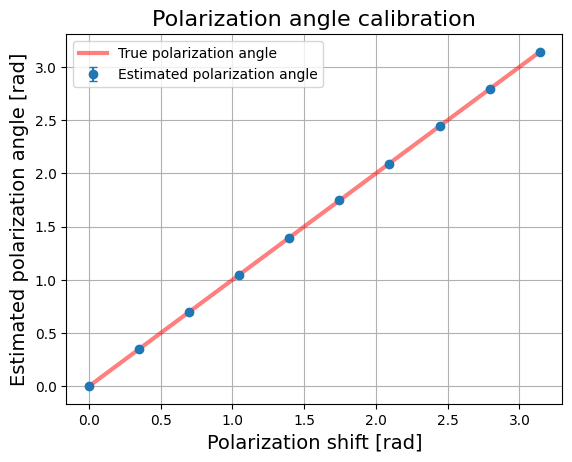

In [13]:
calib_mean = np.unwrap(calibration_results.mean(axis=1), period=np.pi)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarization_shift_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated polarization angle")
plt.plot(polarization_shift_list, polarization_shift_list, c='r', alpha=0.5, lw=3, label="True polarization angle")
plt.xlabel("Polarization shift [rad]", fontsize=14)
plt.ylabel("Estimated polarization angle [rad]", fontsize=14)
plt.title("Polarization angle calibration", fontsize=16)
plt.grid()
plt.legend()
plt.show()

## Camera polarizance calibration

In [14]:
polarization_angle = 0.1  # Polarization angle of the observation
polarization_angle_diff = np.pi / parser["n_polarization_ang"]  # Polarization angle difference between the polarization angles

In [15]:
polarizance_list = np.linspace(0.5, 1, 10)  # Polarizance of the observation
calibration_results = []
for polarizance in polarizance_list:
    df_ind = polarization_angle_diff * np.arange(parser["n_polarization_ang"])
    make_img = lambda p: zodipol.make_camera_images(obs, p, polarization_angle+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=False)

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = zodipol.make_camera_images(obs, polarizance, polarization_angle+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=False)
        cost_function = lambda p: 1e23*(make_img(p) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0.5, bounds=(0, 1), diff_step=10)
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated Polarizance for P={polarizance:.2f}: {np.mean(polarization_angle_res):.2f} +/- {np.std(polarization_angle_res):.2f}")
calibration_results = np.array(calibration_results).squeeze()

Estimated Polarizance for P=0.50: 0.50 +/- 0.00
Estimated Polarizance for P=0.56: 0.56 +/- 0.00
Estimated Polarizance for P=0.61: 0.61 +/- 0.00
Estimated Polarizance for P=0.67: 0.67 +/- 0.00
Estimated Polarizance for P=0.72: 0.72 +/- 0.00
Estimated Polarizance for P=0.78: 0.78 +/- 0.00
Estimated Polarizance for P=0.83: 0.83 +/- 0.00
Estimated Polarizance for P=0.89: 0.89 +/- 0.00
Estimated Polarizance for P=0.94: 0.94 +/- 0.00
Estimated Polarizance for P=1.00: 1.00 +/- 0.00


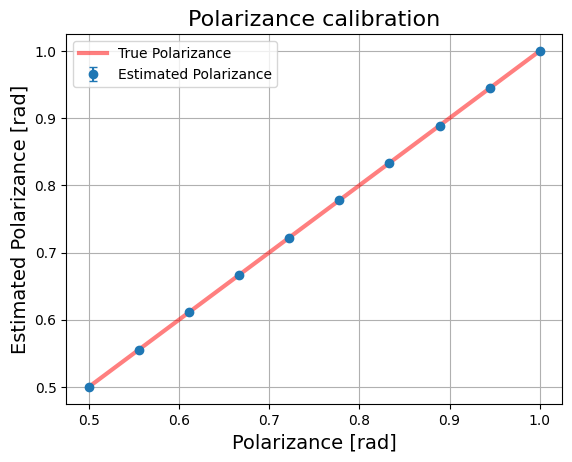

In [16]:
calib_mean = calibration_results.mean(axis=1)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarizance_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated Polarizance")
plt.plot(polarizance_list, polarizance_list, c='r', alpha=0.5, lw=3, label="True Polarizance")
plt.xlabel("Polarizance [rad]", fontsize=14)
plt.ylabel("Estimated Polarizance [rad]", fontsize=14)
plt.title("Polarizance calibration", fontsize=16)
plt.grid()
plt.legend()
plt.show()

## Calibrate birefringence

### Birefringence matrix example

In [60]:
biref_amount = zodipol.imager._get_birefringence_mat(2*np.pi, 'center', flat=True, std=3)
biref_angle = zodipol.imager._get_birefringence_mat(np.pi/4, 'constant', flat=True)
biref_mueller = zodipol.imager.get_birefringence_mueller_matrix(biref_amount, biref_angle)

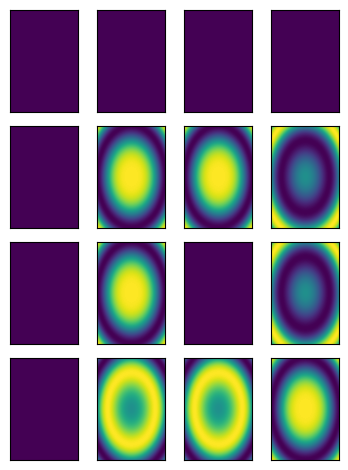

In [54]:
fig, ax = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(biref_mueller[:, i, j].reshape(parser["resolution"]))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
plt.tight_layout(w_pad=-15.0, h_pad=1.0)
plt.show()

### Birefringence calibration

In [6]:
def make_biref_img(delta, theta, **kwargs):
    biref_amount = zodipol.imager._get_birefringence_mat(delta, 'center', flat=True, std=3)
    biref_angle = zodipol.imager._get_birefringence_mat(theta, 'constant', flat=True)
    biref_mueller = zodipol.imager.get_birefringence_mueller_matrix(biref_amount, biref_angle)
    biref_obs = zodipol.imager.apply_birefringence(obs, biref_mueller)
    biref_camera_intensity = zodipol.make_camera_images(biref_obs, parser["polarizance"], parser["polarization_angle"], n_realizations=parser["n_realizations"], **kwargs)
    return biref_camera_intensity

In [7]:
delta, phi = 0.5, 0.1
biref_camera_intensity = make_biref_img(delta, phi, fillna=0, add_noise=False)

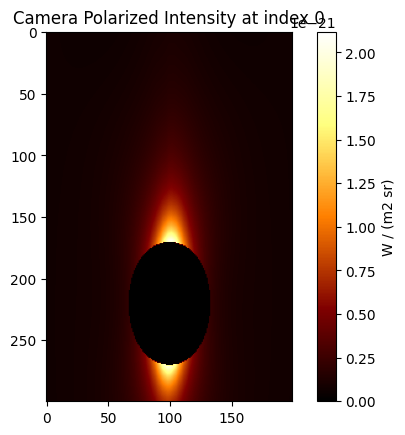

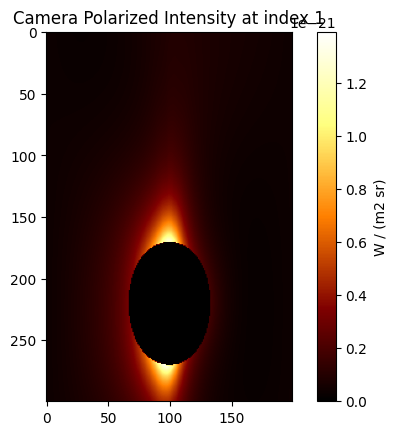

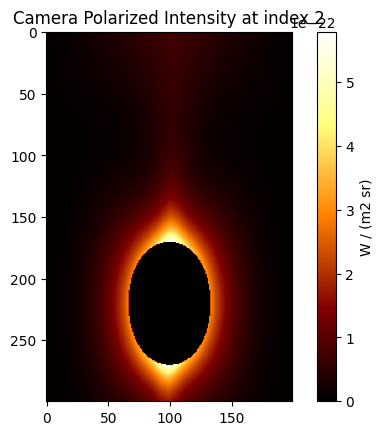

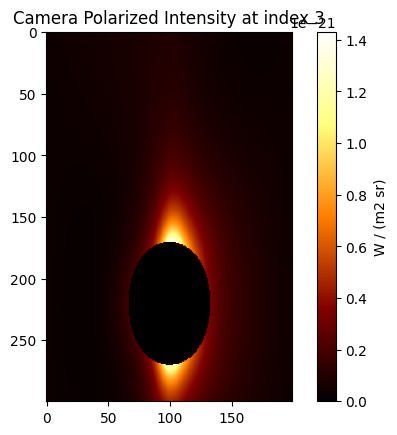

In [8]:
plot_satellite_image_indices(biref_camera_intensity, 4, resolution=parser["resolution"], title="Camera Polarized Intensity")

In [9]:
cost_function = lambda x: 1e23*(make_biref_img(x[0], x[1], fillna=0, add_noise=False) - biref_camera_intensity).value.flatten()
cost1 = lambda d: cost_function((d, phi))
cost2 = lambda p: cost_function((delta, p))
print(delta, phi)

0.5 0.1


In [18]:
res = least_squares(cost1, x0=1, bounds=(0, 2*np.pi))
res.x

array([0.5])

In [20]:
res = least_squares(cost2, x0=0.5, bounds=(0, np.pi/2))
res.x

array([0.1])

In [ ]:
polarizance_list = np.linspace(0.5, 1, 10)  # Polarizance of the observation
calibration_results = []
for polarizance in polarizance_list:
    df_ind = polarization_angle_diff * np.arange(parser["n_polarization_ang"])
    make_img = lambda p: zodipol.make_camera_images(obs, p, polarization_angle+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=False)

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = zodipol.make_camera_images(obs, polarizance, polarization_angle+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=False)
        cost_function = lambda p: 1e23*(make_img(p) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0.5, bounds=(0, 1), diff_step=10)
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated Polarizance for P={polarizance:.2f}: {np.mean(polarization_angle_res):.2f} +/- {np.std(polarization_angle_res):.2f}")
calibration_results = np.array(calibration_results).squeeze()